Isolating the Transient to Speed up Training Time and hopefully Accuracy Too

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import MiniRocketMultivariateVariable
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from module import my_improved_bayesian_change_point_detection, load_data, preprocess_bluetooth_signals
from rf_classifier import RFClassifier

In [3]:
# Set the root directory
root_directory = os.path.join(os.path.join(os.getcwd(), 'Bluetooth Datasets'), 'Dataset 5 Gsps')

In [4]:
# Load the data
data = load_data(root_directory)

In [5]:
print(data.head())

                                              signal  \
0  0        0.0033
1        0.0037
2        0.002...   
1  0        0.0031
1        0.0037
2        0.001...   
2  0        0.0033
1        0.0041
2        0.002...   
3  0        0.0035
1        0.0035
2        0.003...   
4  0        0.0039
1        0.0039
2        0.003...   

                                 label  \
0  Iphone/5/013409009258565_gamze_uyuk   
1  Iphone/5/013409009258565_gamze_uyuk   
2  Iphone/5/013409009258565_gamze_uyuk   
3  Iphone/5/013409009258565_gamze_uyuk   
4  Iphone/5/013409009258565_gamze_uyuk   

                                            filename  
0  013409009258565_gamze_uyuk_ro_iphone_5_record0...  
1  013409009258565_gamze_uyuk_ro_iphone_5_record0...  
2  013409009258565_gamze_uyuk_ro_iphone_5_record0...  
3  013409009258565_gamze_uyuk_ro_iphone_5_record0...  
4  013409009258565_gamze_uyuk_ro_iphone_5_record0...  


In [6]:
print(data['label'].value_counts())

label
Iphone/5/013409009258565_gamze_uyuk                150
Iphone/5/013737001703349_makbule_guclu             150
Iphone/5s/352053069423260_mustafa_gungor           150
Iphone/6/354427066558690_mustafa_guclu             150
Iphone/6/355401074766578_berat_serefoglu           150
Iphone/6s/355694077593599_deniz_yilmaz             150
Iphone/6s/353308076325778_tugce_ozkan              150
LG/G4/352334073607175_mert_kilic                   150
LG/G4/352334072148270_mertcan_yurtseven            150
Samsung/S5/353812060996205_melisa_oktem            150
Samsung/S5/353812063461314_ismet_buyukkilic        150
Samsung/note3/359542051326328_gulden_vatansever    150
Samsung/note3/359543054106238_burak_uyuk           150
Sony/XperiaM5/354188070809491_firat_vural          150
Sony/XperiaM5/354188076543367_leman_cetindere      150
Iphone/6s/355396082974273_melisa_oktem             149
Iphone/5s/359261061140526_melisa_topcu             149
Name: count, dtype: int64


New Section: Preprocess data by removing spur signals, normalizing, applying hilbert transform, and isolating transient

In [7]:
preprocessed_data = preprocess_bluetooth_signals(data, signal_column='signal', dataset='A')

Preprocessing 2548 signals from dataset A...
Processing signal 1/2548...
Processing signal 1001/2548...
Processing signal 2001/2548...
Preprocessing complete!


In [8]:
preprocessed_data['transient'] = None
for idx, row in preprocessed_data.iterrows():
    analytic_signal = row['analytic_signal']
    start_idx, end_idx, _, _ = my_improved_bayesian_change_point_detection(analytic_signal, window_size=600, overlap=0.65, start_threshold=10, end_threshold=2)
    preprocessed_data.at[idx, 'transient'] = analytic_signal[start_idx:end_idx]

In [9]:
for idx, row in preprocessed_data.iterrows():
    print(f'Length of original signal: {len(row['signal'])}')
    print(f'Type of original signal: {type(row['signal'])}')
    print(f'Length of filtered signal: {len(row['filtered_signal'])}')
    print(f'Type of filtered signal: {type(row['filtered_signal'])}')
    print(f'Length of normalized signal: {len(row['normalized_signal'])}')
    print(f'Type of normalized signal: {type(row['normalized_signal'])}')
    print(f'Length of analytic signal: {len(row['analytic_signal'])}')
    print(f'Type of analytic signal: {type(row['analytic_signal'])}')
    print(f'Length of I data: {len(row['I_data'])}')
    print(f'Type of I data: {type(row['I_data'])}')
    print(f'Length of Q data: {len(row['Q_data'])}')
    print(f'Type of Q data: {type(row['Q_data'])}')
    print(f'Length of transient: {len(row['transient'])}')
    print(f'Type of transient: {type(row['transient'])}')
    break

Length of original signal: 40001
Type of original signal: <class 'pandas.core.series.Series'>
Length of filtered signal: 40001
Type of filtered signal: <class 'numpy.ndarray'>
Length of normalized signal: 40001
Type of normalized signal: <class 'numpy.ndarray'>
Length of analytic signal: 40001
Type of analytic signal: <class 'numpy.ndarray'>
Length of I data: 40001
Type of I data: <class 'numpy.ndarray'>
Length of Q data: 40001
Type of Q data: <class 'numpy.ndarray'>
Length of transient: 3150
Type of transient: <class 'numpy.ndarray'>


In [10]:
def extract_transient_features(transient, fs):
    """Extract 9 HOS features + duration from a transient signal"""
    # Convert pandas Series to numpy array
    analytic = transient
    
    # Compute analytic signal
    # analytic = hilbert(signal)
    
    # Instantaneous characteristics
    amplitude = np.abs(analytic)
    amplitude_centered = amplitude - np.mean(amplitude)

    phase = np.unwrap(np.angle(analytic))
    time = 1 / fs
    mu_f = np.mean(np.diff(phase)/(2 * np.pi))  # Mean frequency
    phase_nonlinear = phase - 2 * np.pi * mu_f * time
    phase_centered = phase_nonlinear - np.mean(phase_nonlinear)

    frequency = np.diff(phase)/(2*np.pi)  # Handle length mismatch
    frequency_centered = frequency - np.mean(frequency)
    
    # Calculate HOS features
    features = {
        'amp_var': np.var(amplitude_centered),
        'amp_skew': skew(amplitude_centered, bias=False),
        'amp_kurt': kurtosis(amplitude_centered, fisher=True, bias=False),
        'phase_var': np.var(phase_centered),
        'phase_skew': skew(phase_centered, bias=False),
        'phase_kurt': kurtosis(phase_centered, fisher=True, bias=False),
        'freq_var': np.var(frequency_centered) if len(frequency) > 0 else 0,
        'freq_skew': skew(frequency_centered, bias=False) if len(frequency) > 0 else 0,
        'freq_kurt': kurtosis(frequency_centered, fisher=True, bias=False) if len(frequency) > 0 else 0,
        'duration': len(analytic)
    }
    
    return features

In [11]:
# Normalize and center features
def normalize_features(df):
    """Z-score normalization for all feature columns"""
    normalized_df = df.copy()
    for col in normalized_df.columns:
        if col != 'duration':
            mean = normalized_df[col].mean()
            std = normalized_df[col].std()
            normalized_df[col] = (normalized_df[col] - mean)/std
    return normalized_df

In [12]:
# Extract features for all transients
# feature_df = preprocessed_data['transient'].apply(extract_transient_features).apply(pd.Series)
feature_df = preprocessed_data['transient'].apply(
    lambda x: extract_transient_features(x, fs=5e9)
).apply(pd.Series)

In [13]:
feature_df.head()

,amp_var,amp_skew,amp_kurt,phase_var,phase_skew,phase_kurt,freq_var,freq_skew,freq_kurt,duration
0,0.043988,-0.025101,-0.732932,3300.627397,0.249757,-1.369913,0.155998,-0.068003,-1.865521,3150.0
1,0.042248,0.016791,-0.713867,10738.022404,0.398651,-1.110200,0.144061,-0.123259,-1.815781,2940.0
2,0.042681,0.012789,-0.782736,6407.701728,0.458027,-0.913270,0.147467,-0.093982,-1.823824,3150.0
3,0.041737,0.047670,-0.739036,5627.990509,0.516962,-1.040573,0.142411,-0.097559,-1.812960,2940.0
4,0.041123,0.017873,-0.711535,6115.227130,0.752349,-0.914314,0.139769,-0.105345,-1.815670,2730.0


In [14]:
# Apply normalization (excluding duration initially)
normalized_features = normalize_features(feature_df)

In [15]:
# Normalize duration separately
duration_mean = feature_df['duration'].mean()
duration_std = feature_df['duration'].std()
normalized_features['duration'] = (feature_df['duration'] - duration_mean)/duration_std

In [16]:
for col in normalized_features.columns:
    q1 = normalized_features[col].quantile(0.25)
    q3 = normalized_features[col].quantile(0.75)
    iqr = q3 - q1
    # outliers = normalized_features[(normalized_features[col] < (q1 - 1.5*iqr)) | (normalized_features[col] > (q3 + 1.5*iqr))]
    outliers = normalized_features[(normalized_features[col] < -3.5) | (normalized_features[col] > 3.5)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(normalized_features):.1%})")

amp_var: 60 outliers (2.4%)
amp_skew: 7 outliers (0.3%)
amp_kurt: 9 outliers (0.4%)
phase_var: 44 outliers (1.7%)
phase_skew: 15 outliers (0.6%)
phase_kurt: 15 outliers (0.6%)
freq_var: 0 outliers (0.0%)
freq_skew: 43 outliers (1.7%)
freq_kurt: 3 outliers (0.1%)
duration: 0 outliers (0.0%)


In [17]:
clipped_features = normalized_features.copy()

# Clip features between -3 and 3 (z-score units)
for col in clipped_features.columns:
    clipped_features[col] = np.clip(clipped_features[col], -3.5, 3.5)

# Add normalized features back to original dataframe
# complete_df = pd.concat([preprocessed_data, normalized_features], axis=1)
complete_df = pd.concat([preprocessed_data, clipped_features], axis=1)

In [18]:
preprocessed_data.head()

,signal,label,filename,filtered_signal,normalized_signal,analytic_signal,I_data,Q_data,transient
0,0 0.0033 1 0.0037 2 0.002...,Iphone/5/013409009258565_gamze_uyuk,013409009258565_gamze_uyuk_ro_iphone_5_record0...,"[0.0033, 0.0037, 0.0029, 0.0033, 0.0031, 0.003...","[0.18857142857142856, 0.2114285714285714, 0.16...","[(0.18857142857142867-0.7898769431704035j), (0...","[0.18857142857142867, 0.21142857142857138, 0.1...","[-0.7898769431704035, 0.4880644065043696, -0.4...","[(0.08571428571428569+0.11018569312407152j), (..."
1,0 0.0031 1 0.0037 2 0.001...,Iphone/5/013409009258565_gamze_uyuk,013409009258565_gamze_uyuk_ro_iphone_5_record0...,"[0.0031, 0.0037, 0.0017, 0.0041, 0.0041, 0.003...","[0.19254658385093168, 0.2298136645962733, 0.10...","[(0.19254658385093146-0.7767565119435179j), (0...","[0.19254658385093146, 0.22981366459627312, 0.1...","[-0.7767565119435179, 0.47318468485819104, -0....","[(0.15527950310559002+0.16044909196380625j), (..."
2,0 0.0033 1 0.0041 2 0.002...,Iphone/5/013409009258565_gamze_uyuk,013409009258565_gamze_uyuk_ro_iphone_5_record0...,"[0.0033, 0.0041, 0.0029, 0.0033, 0.0027, 0.003...","[0.19075144508670522, 0.2369942196531792, 0.16...","[(0.19075144508670502-0.6742843875958302j), (0...","[0.19075144508670502, 0.23699421965317927, 0.1...","[-0.6742843875958302, 0.21127063040912833, -0....","[(0.23699421965317963-0.12419087415306605j), (..."
3,0 0.0035 1 0.0035 2 0.003...,Iphone/5/013409009258565_gamze_uyuk,013409009258565_gamze_uyuk_ro_iphone_5_record0...,"[0.0035, 0.0035, 0.0035, 0.0041, 0.0045, 0.003...","[0.20710059171597636, 0.20710059171597636, 0.2...","[(0.20710059171597586+0.10583288895493895j), (...","[0.20710059171597586, 0.20710059171597647, 0.2...","[0.10583288895493895, 0.0967974458841826, -0.0...","[(0.301775147928994+0.11176988483671349j), (0...."
4,0 0.0039 1 0.0039 2 0.003...,Iphone/5/013409009258565_gamze_uyuk,013409009258565_gamze_uyuk_ro_iphone_5_record0...,"[0.0039, 0.0039, 0.0033, 0.0037, 0.0035, 0.004...","[0.2392638036809816, 0.2392638036809816, 0.202...","[(0.2392638036809817-0.7355591243003309j), (0....","[0.2392638036809817, 0.2392638036809814, 0.202...","[-0.7355591243003309, 0.2847687808493694, -0.3...","[(0.3865030674846624+0.09490448189528847j), (0..."


In [19]:
complete_df.head(20)

,signal,label,filename,filtered_signal,normalized_signal,analytic_signal,I_data,Q_data,transient,amp_var,amp_skew,amp_kurt,phase_var,phase_skew,phase_kurt,freq_var,freq_skew,freq_kurt,duration
0,0 0.0033 1 0.0037 2 0.002...,Iphone/5/013409009258565_gamze_uyuk,013409009258565_gamze_uyuk_ro_iphone_5_record0...,"[0.0033, 0.0037, 0.0029, 0.0033, 0.0031, 0.003...","[0.18857142857142856, 0.2114285714285714, 0.16...","[(0.18857142857142867-0.7898769431704035j), (0...","[0.18857142857142867, 0.21142857142857138, 0.1...","[-0.7898769431704035, 0.4880644065043696, -0.4...","[(0.08571428571428569+0.11018569312407152j), (...",-0.169220,-0.419587,0.032838,-0.275126,-1.181890,-0.754784,0.760843,0.429495,-0.663362,-0.647283
1,0 0.0031 1 0.0037 2 0.001...,Iphone/5/013409009258565_gamze_uyuk,013409009258565_gamze_uyuk_ro_iphone_5_record0...,"[0.0031, 0.0037, 0.0017, 0.0041, 0.0041, 0.003...","[0.19254658385093168, 0.2298136645962733, 0.10...","[(0.19254658385093146-0.7767565119435179j), (0...","[0.19254658385093146, 0.22981366459627312, 0.1...","[-0.7767565119435179, 0.47318468485819104, -0....","[(0.15527950310559002+0.16044909196380625j), (...",-0.296105,-0.244064,0.088037,-0.263248,-0.762156,-0.437859,0.507176,-1.242966,-0.561513,-0.658734
2,0 0.0033 1 0.0041 2 0.002...,Iphone/5/013409009258565_gamze_uyuk,013409009258565_gamze_uyuk_ro_iphone_5_record0...,"[0.0033, 0.0041, 0.0029, 0.0033, 0.0027, 0.003...","[0.19075144508670522, 0.2369942196531792, 0.16...","[(0.19075144508670502-0.6742843875958302j), (0...","[0.19075144508670502, 0.23699421965317927, 0.1...","[-0.6742843875958302, 0.21127063040912833, -0....","[(0.23699421965317963-0.12419087415306605j), (...",-0.264529,-0.260834,-0.111359,-0.270164,-0.594774,-0.197549,0.579559,-0.356829,-0.577984,-0.647283
3,0 0.0035 1 0.0035 2 0.003...,Iphone/5/013409009258565_gamze_uyuk,013409009258565_gamze_uyuk_ro_iphone_5_record0...,"[0.0035, 0.0035, 0.0035, 0.0041, 0.0045, 0.003...","[0.20710059171597636, 0.20710059171597636, 0.2...","[(0.20710059171597586+0.10583288895493895j), (...","[0.20710059171597586, 0.20710059171597647, 0.2...","[0.10583288895493895, 0.0967974458841826, -0.0...","[(0.301775147928994+0.11176988483671349j), (0....",-0.333360,-0.114683,0.015167,-0.271409,-0.428636,-0.352895,0.472112,-0.465092,-0.555737,-0.658734
4,0 0.0039 1 0.0039 2 0.003...,Iphone/5/013409009258565_gamze_uyuk,013409009258565_gamze_uyuk_ro_iphone_5_record0...,"[0.0039, 0.0039, 0.0033, 0.0037, 0.0035, 0.004...","[0.2392638036809816, 0.2392638036809816, 0.202...","[(0.2392638036809817-0.7355591243003309j), (0....","[0.2392638036809817, 0.2392638036809814, 0.202...","[-0.7355591243003309, 0.2847687808493694, -0.3...","[(0.3865030674846624+0.09490448189528847j), (0...",-0.378110,-0.239532,0.094790,-0.270631,0.234922,-0.198823,0.415967,-0.700771,-0.561287,-0.670186
5,0 0.0047 1 0.0035 2 0.003...,Iphone/5/013409009258565_gamze_uyuk,013409009258565_gamze_uyuk_ro_iphone_5_record0...,"[0.0047, 0.0035, 0.0035, 0.0029, 0.0039, 0.003...","[0.281437125748503, 0.2095808383233533, 0.2095...","[(0.2814371257485033+0.6017559999668728j), (0....","[0.2814371257485033, 0.2095808383233532, 0.209...","[0.6017559999668728, -0.10696941637406925, 0.2...","[(0.14970059880239517-0.1260517089033561j), (0...",-0.287576,-0.248427,0.042585,-0.270444,0.472492,0.251029,0.609489,-0.593580,-0.615935,-0.658734
6,0 0.0035 1 0.0029 2 0.003...,Iphone/5/013409009258565_gamze_uyuk,013409009258565_gamze_uyuk_ro_iphone_5_record0...,"[0.0035, 0.0029, 0.0033, 0.0049, 0.0035, 0.002...","[0.2023121387283237, 0.1676300578034682, 0.190...","[(0.2023121387283238-0.7566377685878486j), (0....","[0.2023121387283238, 0.167630057803468, 0.1907...","[-0.7566377685878486, 0.42298247038639375, -0....","[(0.17919075144508675+0.14405296149169475j), (...",-0.218640,-0.367114,-0.013134,-0.272338,0.448062,0.261988,0.638424,-0.188513,-0.611708,-0.647283
7,0 0.0043 1 0.0033 2 0.004...,Iphone/5/013409009258565_gamze_uyuk,013409009258565_gamze_uyuk_ro_iphone_5_record0...,"[0.0

In [20]:
# Verify feature columns
print(complete_df[['amp_var',
       'amp_skew', 'amp_kurt', 'phase_var', 'phase_skew', 'phase_kurt',
       'freq_var', 'freq_skew', 'freq_kurt', 'duration']].head())
print(complete_df.columns)

    amp_var  amp_skew  amp_kurt  phase_var  phase_skew  phase_kurt  freq_var  \
0 -0.169220 -0.419587  0.032838  -0.275126   -1.181890   -0.754784  0.760843   
1 -0.296105 -0.244064  0.088037  -0.263248   -0.762156   -0.437859  0.507176   
2 -0.264529 -0.260834 -0.111359  -0.270164   -0.594774   -0.197549  0.579559   
3 -0.333360 -0.114683  0.015167  -0.271409   -0.428636   -0.352895  0.472112   
4 -0.378110 -0.239532  0.094790  -0.270631    0.234922   -0.198823  0.415967   

   freq_skew  freq_kurt  duration  
0   0.429495  -0.663362 -0.647283  
1  -1.242966  -0.561513 -0.658734  
2  -0.356829  -0.577984 -0.647283  
3  -0.465092  -0.555737 -0.658734  
4  -0.700771  -0.561287 -0.670186  
Index(['signal', 'label', 'filename', 'filtered_signal', 'normalized_signal',
       'analytic_signal', 'I_data', 'Q_data', 'transient', 'amp_var',
       'amp_skew', 'amp_kurt', 'phase_var', 'phase_skew', 'phase_kurt',
       'freq_var', 'freq_skew', 'freq_kurt', 'duration'],
      dtype='object')


In [21]:
device = torch.device('cuda')
torch.manual_seed(0)

In [22]:
def prepare_data(df, test_size=0.2, random_state=42):
    # Encode labels
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    
    # Extract features and labels
    feature_cols = [col for col in df.columns if col not in ['label', 'label_encoded']]
    X = df[feature_cols].values
    y = df['label_encoded'].values
    
    # Stratified split (120 train, 30 test per class)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        stratify=y,
        random_state=random_state
    )

    # Normalize features
    # scaler = StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, le.classes_

In [23]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=2500, lr=0.0001):
    # Convert to tensors
    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long)
    )
    
    test_dataset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.long)
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    # Initialize model, loss, optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr ,weight_decay=0.001)
    scheduler = StepLR(optimizer, step_size=500, gamma=0.9)

    # Track accuracies
    train_accuracies = []
    test_accuracies = []
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track training accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
        # Calculate epoch training accuracy
        train_acc = 100 * train_correct / train_total
        train_accuracies.append(train_acc)
        
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        test_acc = 100 * test_correct / test_total
        test_accuracies.append(test_acc)
        # print(f'Epoch {epoch+1}/{epochs}, Test Acc: {100*test_correct/test_total:.2f}%')
        scheduler.step()
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training vs Test Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f'Max Accuracy: {np.max(test_accuracies)} at epoch {np.argmax(test_accuracies) + 1}')
    return model

In [24]:
def evaluate_model(model, X_test, y_test):
    # test_dataset = TensorDataset(
    #     torch.tensor(X_test, dtype=torch.float32, device=device),
    #     torch.tensor(y_test, dtype=torch.long, device=device)
    # )
    test_dataset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.long)
    )
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    final_acc = 100 * correct / total
    print(f'Final Test Accuracy: {final_acc:.1f}%')
    return final_acc

In [25]:
nn_df = complete_df[['label', 'amp_var',
       'amp_skew', 'amp_kurt', 'phase_var', 'phase_skew', 'phase_kurt',
       'freq_var', 'freq_skew', 'freq_kurt', 'duration']]

# Prepare data
X_train, X_test, y_train, y_test, classes = prepare_data(nn_df, random_state=0)

# Initialize model
model = RFClassifier(input_size=X_train.shape[1], hidden_size=128, num_classes=len(classes), dropout_rate=0.4) # .to(device)
print(model)

RFClassifier(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=128, out_features=17, bias=True)
  )
)


/tmp/ipykernel_22785/2895676867.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_encoded'] = le.fit_transform(df['label'])


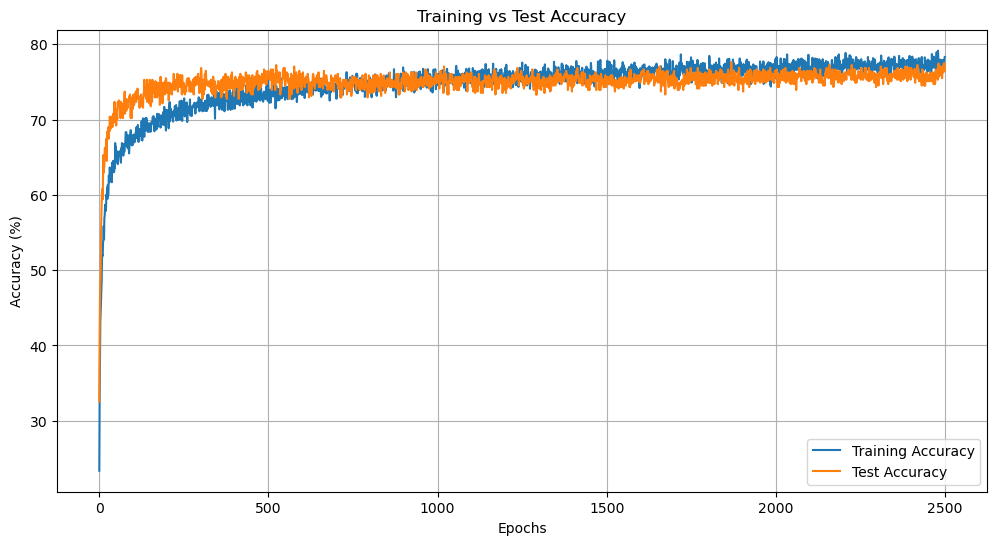

Max Accuracy: 77.6470588235294 at epoch 1869
Final Test Accuracy: 76.5%


76.47058823529412

In [26]:
# with torch.device(device):
#        trained_model = train_model(model, X_train, y_train, X_test, y_test)
#        evaluate_model(trained_model, X_test, y_test)
trained_model = train_model(model, X_train, y_train, X_test, y_test, epochs=2500, lr=1e-3)
evaluate_model(trained_model, X_test, y_test)